In [14]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [15]:
from backtesting import Backtest
from strategies import PairTradeMeanReversion
import numpy as np
import pandas as pd
import numpy as np
import yfinance as yf
np.int = int

In [28]:
def create_pair(tkr_1: str, tkr_2: str) -> pd.DataFrame:
    df_1 = yf.Ticker(tkr_1).history(start='2014-01-01', end=None)
    df_2 = yf.Ticker(tkr_2).history(start='2014-01-01', end=None)
    df_1.index = pd.DatetimeIndex(df_1.index)
    df_2.index = pd.DatetimeIndex(df_2.index)

    pair_df = df_1.join(df_2, rsuffix='_y').dropna()
    pair_df.index = pair_df.index.tz_localize(None).astype('datetime64[ns]')
    return pair_df.reset_index()

In [27]:
from backtesting import Strategy
import pandas as pd

import common.util as util

class PairTradeMeanReversion(Strategy):
    rolling_days = 30

    def init(self):
        self.ratio = util.norm_pairs(self.data, 'Close_x', 'Close_y').dropna().copy()

    def next(self):
        print(self)

In [29]:
df = create_pair('AAPL', 'MSFT')
print(df.head())
rma_bt = Backtest(df, PairTradeMeanReversion,
                  cash=100000, commission=.002,
                  exclusive_orders=True)
rma_bt.run()

/home/adam/.local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/home/adam/.local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/tmp/ipykernel_63019/986526621.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  rma_bt = Backtest(df, PairTradeMeanReversion,


        Date       Open       High        Low      Close     Volume  \
0 2014-01-02  17.376400  17.418615  17.261950  17.296659  234684800   
1 2014-01-03  17.288217  17.314483  16.899524  16.916723  392467600   
2 2014-01-06  16.806336  17.098714  16.685944  17.008968  412610800   
3 2014-01-07  17.021169  17.072452  16.821038  16.887331  317209200   
4 2014-01-08  16.848867  17.059943  16.845116  16.994276  258529600   

   Dividends  Stock Splits     Open_y     High_y      Low_y    Close_y  \
0        0.0           0.0  31.392763  31.434790  31.182637  31.233068   
1        0.0           0.0  31.266680  31.283491  30.762377  31.022934   
2        0.0           0.0  30.972503  31.006124  30.350533  30.367344   
3        0.0           0.0  30.535442  30.669922  30.434579  30.602680   
4        0.0           0.0  30.258082  30.375752  29.905073  30.056360   

   Volume_y  Dividends_y  Stock Splits_y  
0  30632200          0.0             0.0  
1  31134800          0.0             0.0  

AttributeError: Column 'shape' not in data

In [ ]:
stats, heatmap = rma_bt.optimize(rsi_period=[5, 30],
                                 up_thresh=[10, 90],
                                 down_thresh=[10, 90],
                                 confirm_bars=[1, 10],
                                 constraint=lambda p: p.up_thresh > p.down_thresh,
                                 method='skopt',
                                 max_tries=200,
                                 return_heatmap=True)

/Users/adamschueller/Library/Python/3.9/lib/python/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Start                     2017-08-17 04:00:00
End                       2023-10-19 23:00:00
Duration                   2254 days 19:00:00
Exposure Time [%]                     0.13892
Equity Final [$]                   10575.4228
Equity Peak [$]                    10575.4228
Return [%]                           5.754228
Buy & Hold Return [%]               419.40254
Return (Ann.) [%]                    0.909695
Volatility (Ann.) [%]                2.633467
Sharpe Ratio                         0.345436
Sortino Ratio                        0.957443
Calmar Ratio                         0.115747
Max. Drawdown [%]                   -7.859367
Avg. Drawdown [%]                   -3.143928
Max. Drawdown Duration        2 days 20:00:00
Avg. Drawdown Duration        1 days 00:00:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                       5.947547
Worst Trade [%]                     -0.145118
Avg. Trade [%]                    

<Axes: xlabel='rsi_period,up_thresh,down_thresh,confirm_bars'>

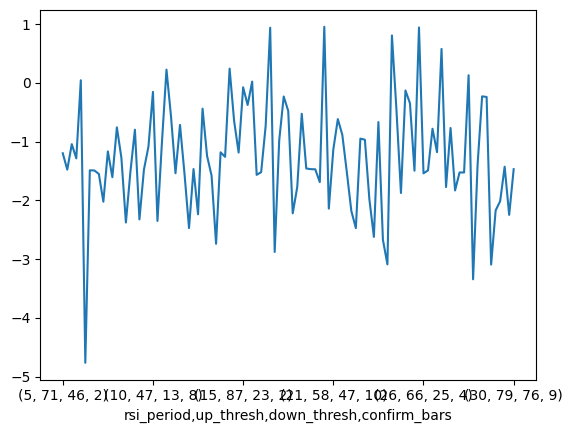

In [ ]:
print(stats)
print(heatmap.sort_values())
heatmap.plot()